# Library Import

In [16]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import cv2
import os

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
# faster rcnn model이 포함된 library
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead

from torch.utils.data import DataLoader, Dataset
import pandas as pd
from tqdm import tqdm
import random

In [ ]:
def small_centered_random_crop(image, boxes, labels,
                               p=0.3,
                               small_thr=64*64,
                               min_scale=0.5,
                               max_scale=0.9):
    if random.random() > p:
        return image, boxes, labels

    if boxes.size(0) == 0:
        return image, boxes, labels

    H, W, _ = image.shape
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    small_mask = areas < small_thr

    if small_mask.sum() == 0:
        return image, boxes, labels

    idx = small_mask.nonzero(as_tuple=False).flatten()[0].item()
    bx = boxes[idx]
    x1, y1, x2, y2 = bx.tolist()

    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2

    scale = random.uniform(min_scale, max_scale)
    crop_w = int(W * scale)
    crop_h = int(H * scale)

    left = int(max(0, cx - crop_w / 2))
    top = int(max(0, cy - crop_h / 2))
    right = min(W, left + crop_w)
    bottom = min(H, top + crop_h)

    crop_img = image[top:bottom, left:right]
    ch, cw = crop_img.shape[:2]

    new_boxes = boxes.clone()

    new_boxes[:, [0, 2]] -= left
    new_boxes[:, [1, 3]] -= top

    new_boxes[:, 0::2] = new_boxes[:, 0::2].clamp(0, cw - 1)
    new_boxes[:, 1::2] = new_boxes[:, 1::2].clamp(0, ch - 1)

    valid = (new_boxes[:, 2] > new_boxes[:, 0]) & (new_boxes[:, 3] > new_boxes[:, 1])
    if valid.sum() == 0:
        return image, boxes, labels

    new_boxes = new_boxes[valid]
    new_labels = labels[valid]

    return crop_img, new_boxes, new_labels

# Dataset 생성

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, annotation, data_dir, transforms=None, is_train=False):
        super().__init__()
        self.data_dir = data_dir
        # coco annotation 불러오기 (coco API)
        self.coco = COCO(annotation)
        self.img_ids = self.coco.getImgIds()
        self.predictions = {
            "images": self.coco.dataset["images"].copy(),
            "categories": self.coco.dataset["categories"].copy(),
            "annotations": None
        }
        self.transforms = transforms
        self.is_train = is_train

    def __getitem__(self, index: int):
        image_id = self.img_ids[index]
        image_info = self.coco.loadImgs(image_id)[0]

        image_path = os.path.join(self.data_dir, image_info["file_name"])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        ann_ids = self.coco.getAnnIds(imgIds=image_info["id"])
        anns = self.coco.loadAnns(ann_ids)

        H, W = image.shape[:2]
        img_area = H * W

        boxes = []
        labels = []
        areas = []
        is_crowds = []

        for ann in anns:
            x, y, w, h = ann["bbox"]
            if w <= 0 or h <= 0:
                continue

            x_min = x
            y_min = y
            x_max = x + w
            y_max = y + h

            x_min = max(0, min(x_min, W - 1))
            y_min = max(0, min(y_min, H - 1))
            x_max = max(0, min(x_max, W - 1))
            y_max = max(0, min(y_max, H - 1))
            if x_max <= x_min or y_max <= y_min:
                continue

            box_area = (x_max - x_min) * (y_max - y_min)

            if box_area > 0.85 * img_area:
                continue

            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(ann["category_id"] + 1)  # 1~10
            areas.append(box_area)
            is_crowds.append(int(ann.get("iscrowd", 0)))

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            areas = torch.zeros((0,), dtype=torch.float32)
            is_crowds = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            areas = torch.as_tensor(areas, dtype=torch.float32)
            is_crowds = torch.as_tensor(is_crowds, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([image_id]),
            "area": areas,
            "iscrowd": is_crowds,
        }

        if getattr(self, "is_train", False) and boxes.shape[0] > 0:
            image, boxes, labels = small_centered_random_crop(
                image, boxes, labels,
                p=0.5,
                small_thr=96*96,
                min_scale=0.5,
                max_scale=0.9,
            )
            target["boxes"] = boxes
            target["labels"] = labels
            

        if self.transforms and boxes.shape[0] > 0:
            sample = {
                "image": image, 
                "bboxes": boxes.numpy(), 
                "labels": labels.numpy(), 
            }
            sample = self.transforms(**sample)
            image = sample["image"]     
            boxes = torch.as_tensor(sample["bboxes"], dtype=torch.float32)
            labels = torch.as_tensor(sample["labels"], dtype=torch.int64)
            target["boxes"] = boxes
            target["labels"] = labels
        else:
            image = torch.tensor(image).permute(2, 0, 1).float()
            target["boxes"] = boxes

        return image, target, image_id
    
    def __len__(self) -> int:
        return len(self.img_ids) 

In [ ]:
def get_train_transform():
    return A.Compose([
        A.LongestMaxSize(max_size=1024, p=1.0),
        A.PadIfNeeded(min_height=1024, min_width=1024, border_mode=cv2.BORDER_CONSTANT),
        A.RandomScale(scale_limit=(0.5, 1.5), p=0.5), 
        A.RandomBrightnessContrast(p=0.3),
        A.Flip(p=0.5),
        ToTensorV2(p=1.0),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# WeightedRandomSampler

In [ ]:
from collections import defaultdict
from torch.utils.data import WeightedRandomSampler


from pycocotools.coco import COCO
from collections import defaultdict
import torch

def make_image_weights(annotation_path,
                       rare_ratio=0.1,
                       rare_weight=3.0,
                       normal_weight=1.0,
                       small_thr=96*96,
                       small_img_boost=1.5,
                       small_cnt_thr=1):
    coco = COCO(annotation_path)
    anns = coco.dataset["annotations"]

    cls_count = defaultdict(int)
    img_to_cats = defaultdict(set)
    img_to_boxes = defaultdict(list)

    for ann in anns:
        cid = ann["category_id"]
        img_id = ann["image_id"]
        cls_count[cid] += 1
        img_to_cats[img_id].add(cid)
        img_to_boxes[img_id].append(ann["bbox"])

    max_cnt = max(cls_count.values())
    rare_classes = {
        c for c, n in cls_count.items()
        if n < rare_ratio * max_cnt
    }

    img_ids = coco.getImgIds()
    img_weights = []
    for img_id in img_ids:
        cats = img_to_cats.get(img_id, set())
        base_w = rare_weight if len(cats & rare_classes) > 0 else normal_weight

        boxes = img_to_boxes.get(img_id, [])
        small_cnt = 0
        for x, y, w, h in boxes:
            area = w * h
            if area <= small_thr:
                small_cnt += 1

        if small_cnt >= small_cnt_thr:
            base_w *= small_img_boost 

        img_weights.append(base_w)

    img_weights = torch.DoubleTensor(img_weights)
    return coco, img_ids, img_weights



# Util Functions

In [21]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:

def evaluate(model, data_loader, coco_gt, device):
    model.eval()
    results = []

    with torch.no_grad():
        for images, targets, image_ids in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for out, img_id in zip(outputs, image_ids):
                if isinstance(img_id, (list, tuple)):
                    img_id = img_id[0]
                if isinstance(img_id, torch.Tensor):
                    img_id = img_id.item()

                boxes = out["boxes"].cpu().numpy()
                scores = out["scores"].cpu().numpy()
                labels = out["labels"].cpu().numpy()

                for box, score, label in zip(boxes, scores, labels):
                    x_min, y_min, x_max, y_max = box
                    w = x_max - x_min
                    h = y_max - y_min
                    results.append(
                        {
                            "image_id": int(img_id),
                            "category_id": int(label - 1),
                            "bbox": [float(x_min), float(y_min), float(w), float(h)],
                            "score": float(score),
                        }
                    )


    if len(results) == 0:
        print("No detections.")
        model.train()
        return

    coco_dt = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    model.train()


In [25]:
def train_one_epoch(train_data_loader, optimizer, model, device, epoch):
    model.train()
    loss_hist = Averager()
    loss_hist.reset()

    for images, targets, image_ids in tqdm(train_data_loader, desc=f"Epoch {epoch}"):
        images = [img.float().to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value:.4f}")
    return loss_hist.value


# Main

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_fasterrcnn_v2(num_classes=11):
    weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=weights)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    model.roi_heads.detections_per_img = 300
    model.roi_heads.score_thresh = 0.02

    return model


In [ ]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

def create_model(num_classes=11):
    backbone = resnet_fpn_backbone(
        'resnet101', 
        pretrained=True
    )
    
    anchor_sizes = (
        (32),
        (64,), 
        (128,), 
        (256,), 
        (512,)  
    )
    
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes) 
    
    rpn_anchor_generator = AnchorGenerator(
        sizes=anchor_sizes, 
        aspect_ratios=aspect_ratios 
    )
    
    model = FasterRCNN(
        backbone, 
        num_classes=num_classes,
        rpn_anchor_generator=rpn_anchor_generator
    )
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    model.roi_heads.detections_per_img = 300
    model.roi_heads.score_thresh = 0.02

    return model

In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch

def main():
    train_ann = '../../dataset/train_split.json'
    val_ann   = '../../dataset/val_split.json'
    data_dir  = '../../dataset'

    coco_train, train_ids, img_weights = make_image_weights(
        annotation_path=train_ann,
        rare_ratio=0.1,
        rare_weight=3.0,
        normal_weight=1.0,
    )

    train_dataset = CustomDataset(
        annotation=train_ann,
        data_dir=data_dir,
        transforms=get_train_transform(),
        is_train=True,
    )

    sampler = WeightedRandomSampler(
        weights=img_weights,
        num_samples=len(img_weights),
        replacement=True,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=False,
        sampler=sampler,
        num_workers=2,
        collate_fn=collate_fn,
    )

    val_dataset = CustomDataset(
        annotation=val_ann,
        data_dir=data_dir,
        transforms=get_valid_transform(),
        is_train=False,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=2,
        shuffle=False,
        num_workers=2,
        collate_fn=collate_fn,
    )

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print("device:", device)

    num_classes = 11
    model = create_model(num_classes)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params, lr=0.005, momentum=0.9, weight_decay=0.0005
    )

    
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[8, 11], gamma=0.1
    )

    model.eval()
    images, targets, image_ids = next(iter(val_loader))
    with torch.no_grad():
        outs = model([im.to(device) for im in images])

    pred = outs[0]
    pred_boxes = pred["boxes"].detach().cpu().numpy()
    pred_scores = pred["scores"].detach().cpu().numpy()
    pred_labels = pred["labels"].detach().cpu().numpy()

    print("num_pred:", len(pred_boxes))
    print("scores[:20]:", pred_scores[:20])
    print("labels[:20]:", pred_labels[:20])


    import matplotlib.pyplot as plt
    import cv2
    img = images[0].permute(1, 2, 0).cpu().numpy()
    gt_boxes = targets[0]["boxes"].cpu().numpy()
    pred = outs[0]
    pred_boxes = pred["boxes"].detach().cpu().numpy()
    pred_scores = pred["scores"].detach().cpu().numpy()

    img_vis = (img * 255).astype("uint8").copy()

    for box in gt_boxes:
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

    for box, score in zip(pred_boxes, pred_scores):
        if score < 0.5:
            continue
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_vis)
    plt.axis("off")
    plt.show()

    num_epochs = 3

    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(train_loader, optimizer, model, device, epoch)
        print(f"Epoch #{epoch} loss: {train_loss:.4f}")

        print("Validation evaluation:")
        evaluate(model, val_loader, val_dataset.coco, device)

        lr_scheduler.step()


loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
device: cuda
num_pred: 300
scores[:20]: [0.11847794 0.11834225 0.11740637 0.11703929 0.11685248 0.11651854
 0.11642334 0.11621669 0.11503682 0.11503025 0.11493477 0.11483355
 0.11478721 0.1142688  0.1138838  0.11384758 0.11370168 0.11365889
 0.11339472 0.11290319]
labels[:20]: [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  5 10 10 10]


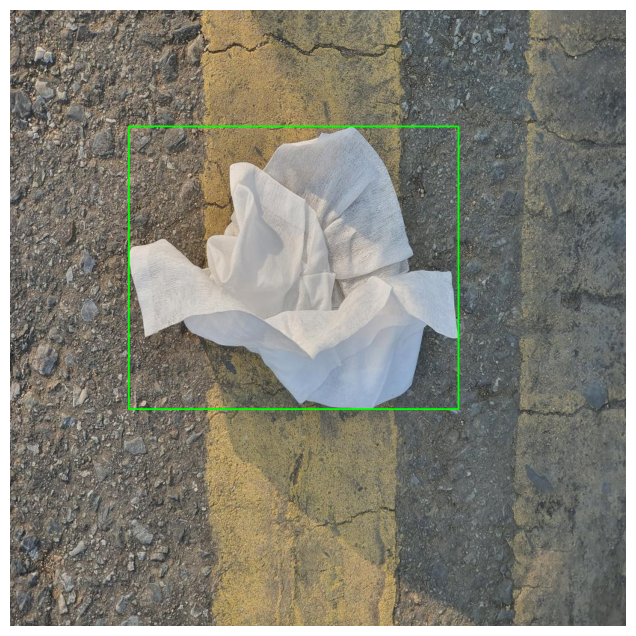

Epoch 1: 100%|██████████| 977/977 [06:00<00:00,  2.71it/s]

Epoch #1 loss: 0.8558
Epoch #1 loss: 0.8558
Validation evaluation:


Loading and preparing results...
DONE (t=0.48s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.50s).
Accumulating evaluation results...
DONE (t=1.84s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.174
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.090
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.277
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 2:  68%|██████▊   | 665/977 [04:05<01:55,  2.70it/s]


KeyboardInterrupt: 

In [30]:
if __name__ == '__main__':
    main()

In [ ]:
from pycocotools.coco import COCO

val_ann = "../../dataset/val_split.json"

coco = COCO(val_ann)
print(coco.cats)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
{0: {'id': 0, 'name': 'General trash', 'supercategory': 'General trash'}, 1: {'id': 1, 'name': 'Paper', 'supercategory': 'Paper'}, 2: {'id': 2, 'name': 'Paper pack', 'supercategory': 'Paper pack'}, 3: {'id': 3, 'name': 'Metal', 'supercategory': 'Metal'}, 4: {'id': 4, 'name': 'Glass', 'supercategory': 'Glass'}, 5: {'id': 5, 'name': 'Plastic', 'supercategory': 'Plastic'}, 6: {'id': 6, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'}, 7: {'id': 7, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'}, 8: {'id': 8, 'name': 'Battery', 'supercategory': 'Battery'}, 9: {'id': 9, 'name': 'Clothing', 'supercategory': 'Clothing'}}
